In [ ]:
import sys
IS_COLAB = 'google.colab' in sys.modules
if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive
    %pip install -r requirements.txt
    !pip install -U kaleido plotly
    import kaleido
    kaleido.get_chrome_sync()

import plotly.io as pio
pio.renderers.default = pio.renderers.default + "+png"

# Last updated: 2025-11-09 13:21:35

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/hw4
  Cloning https://github.com/BerkeleyML/otter-grader-189.git (to revision master) to /tmp/pip-install-srtcl677/otter-grader_2febe38bda674df8864a4ccaf6090cf0
  Running command git clone --filter=blob:none --quiet https://github.com/BerkeleyML/otter-grader-189.git /tmp/pip-install-srtcl677/otter-grader_2febe38bda674df8864a4ccaf6090cf0
  Resolved https://github.com/BerkeleyML/otter-grader-189.git to commit 35e43fdf64a55f4b9222d7b531890fb7d5cb498c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects
import plotly.subplots
import torch
import torch.nn as nn
from torch.optim import AdamW
import torchaudio
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
from transformers import AutoTokenizer, AutoModel

In [4]:
def set_seed():
    """
    Set the seed for all random number generators
    """
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

# Set random seeds for reproducible results
SEED = 42
set_seed()

def get_device():
    """
    Use hardware accelerator if available
    """
    if torch.accelerator.is_available():
        device = torch.accelerator.current_accelerator()
    else:
        device = "cpu"
    print(f"Using device: {device}")
    return device

device = get_device()

IS_GRADING_ENV = os.getenv("IS_GRADING_ENV") == "true"

Using device: cuda



## DNABERT
<div align="center">
<img src="https://i.imgur.com/qJegHdR.jpeg" alt="DNABERT Architecture" width="400"/>
<br>
<caption>
<a href="https://academic.oup.com/bioinformatics/article/37/15/2112/6128680">
Source: Bioinformatics - Ji, Zhou, Liu, and Davuluri
</a>
</caption>
</div>

### What is DNABERT?
DNABERT is a deep learning model that adapts the **BERT (Bidirectional Encoder Representations from Transformers)** architecture for DNA sequence analysis. DNA BERT takes in k-mers (DNA sequences split into groups of $k$ letters each) and outputs an embedding for each k-mer token.

### The DNABERT-6 Architecture
DNABERT-6 uses the same architecture as the original BERT model:
* 12 transformer encoder layers
* 768 hidden units per layer
* 12 attention heads
* ~110 million parameters

DNABERT-6 adapts this architecture for DNA sequence data.

### How is DNABERT-6 trained?
It is pre-trained on large amounts of unlabeled genetic data using k-mer tokenization, enabling it to capture both local and long-range dependencies in DNA.

The model is designed to be fine-tuned for various downstream tasks, such as promoter, splice site, or transcription factor binding site prediction, often with limited labeled data.

###  How does DNABERT-6 tokenize DNA sequences?
DNABERT-6 uses k-mer tokenization: each DNA sequence is split into overlapping substrings of length k (e.g., 6-mers for DNA_bert_6). For example, the sequence `ATGGCT` with k=3 becomes `ATG TGG GGC GCT`.

The DNABERT-6 tokenizer expects the input as a space-separated string of k-mers. The DNABERT-6 tokenizer may also add special tokens at the start and end of a sequence of k-mers: `[CLS]` at the start (for classification) and `[SEP]` at the end.

#### Example (DNABERT-6) with 3-mers:
* Split the sequence `ATGGCT` into 3-mers: `"ATG TGG GGC GCT"`
* Tokens: `[CLS], ATG, TGG, GGC, GCT, [SEP]`
* Token IDs: `[101][1234][2345][3456][4567][102]` (example values)

### What is the [CLS] token embedding and how is it used?
The `[CLS]` token is a special token prepended to every input sequence by the DNA BERT Tokenizer. The `[CLS]` token's final hidden state (the encoder's output vector at position 0) is designed to represent the entire sequence.

For classification tasks, the `[CLS]` embedding is typically fed into a classification layer (e.g., a linear layer) to predict the class label. This approach is explicitly described in the DNA BERT paper.

>"As illustrated in Figure 1b, for a DNA sequence, we tokenized it into a sequence of k-mers and added a special token `[CLS]` at the beginning of it (which represents the whole sequence) as well as a special token `[SEP]` at the end (which denotes the end of sequence)."

>Figure 1b caption: "DNABERT uses tokenized k-mer sequences as input, which also contains a CLS token (a tag representing meaning of entire sentence), a SEP token (sentence separator) and MASK tokens (to represent masked k-mers in pre-training). The input passes an embedding layer and is fed to 12 Transformer blocks. The **first output among last hidden states will be used for sentence-level classification** while outputs for individual masked token used for token-level classification."

In code, if your hidden state tensor is `[batch_size, sequence_length, hidden_size]`, then `hidden_state[:, 0, :]` gives you the `[CLS]` embedding for each sequence in the batch.


### How do we use BERT-based models for classification?
Since the pretrained BERT models usually don't include a classification head by default, we can add our own layer (e.g., a linear or MLP layer) at the end of BERT-based model to make predictions using the `[CLS]` token's embedding.

The typical workflow is:
1. Tokenize and encode the sequence into a list of integer Token IDs.
2. Pass through the model to get the hidden states.
3. Extract the `[CLS]` embedding (`hidden_state[:, 0, :]`).
4. Feed this embedding into your classification layer and train on your labeled data.

This is the standard approach for BERT-based models in both genomics and NLP.

### What does the hidden state output of DNABERT look like?
The model's output is a tensor of shape `[batch_size, sequence_length, hidden_size]` (e.g., `[10, 512, 768]`).

The first dimension is the batch size, the second is the number of tokens passed as the input sequence to the DNABERT model (i.e. number of k-mers, up to the model's max length), and the third is the embedding size.

To classify the sequence located at `batch_idx` in our batch, we use the vectors at position `[batch_idx, 0, :]` (the `[CLS]` token embedding) as the input to the classifier.

We have three text files: `chimpanzee_train.txt`, `dog_train.txt`, and `human_train.txt`. Each file contains DNA sequences for a different species.

There are 2 columns in each text file:
* `sequence`: the DNA string (A, T, C, G).
* `class`: an integer that describes which gene family this DNA sequence comes from (G protein coupled receptors, receptors, Tyrosine kinase, Tyorsine phosphatase, Synthetase, Synthase, Ion channel, or Transcription factor). In this homework assignment, we won't actually be using the gene family as our `class`. Rather, we want to predict what species each DNA sequence comes from, so we will create our own `target` class based on whether this DNA sequence belongs to a chimpanzee, dog, or human.

Let's load them in as Pandas Dataframes. We'll create a `target` column based on the species the DNA comes from to use for prediction. Ideally, when training our classifier, we want our model to see an equal proportion of all the classes. The number of sequences (rows) in each txt file is not the same, so we need to create a combined dataset with an even class distribution (i.e. same number of examples for each species). We can calculate which species has the fewest DNA sequences, sample exactly that number of DNA sequences from all three species, and concatenate them together into a combined dataframe to use for training later!

Acknowledgements: Şükrü Ozan, ["DNA Sequence Classification with Compressor"](https://arxiv.org/abs/2401.14025), GitHub Repository: [Source](https://github.com/sukruozan/DNA-Sequence-Classification)

<!-- BEGIN QUESTION -->



In [ ]:
set_seed() # Resets the global seed state for reproducibility

# Map of species name to class ID
species_to_target = {
    'chimpanzee': 0,
    'dog': 1,
    'human': 2
}

# Map of targets (class IDs) to species name
target_to_species = {
    target: species for species, target in species_to_target.items()
}

chimpanzee_df = pd.read_table("chimpanzee_train.txt")
dog_df = pd.read_table("dog_train.txt")
human_df = pd.read_table("human_train.txt")

chimpanzee_df["species"] = "chimpanzee"
chimpanzee_df["target"] = species_to_target["chimpanzee"]
dog_df["species"] = "dog"
dog_df["target"] = species_to_target["dog"]
human_df["species"] = "human"
human_df["target"] = species_to_target["human"]
chimpanzee_df = chimpanzee_df.rename(columns={"class": "gene_family"})
dog_df = dog_df.rename(columns={"class": "gene_family"})
human_df = human_df.rename(columns={"class": "gene_family"})

num_samples_per_species = min(len(chimpanzee_df), len(dog_df), len(human_df))

combined_df = pd.concat((dog_df.sample(num_samples_per_species, random_state=SEED),
                         human_df.sample(num_samples_per_species, random_state=SEED),
                         chimpanzee_df.sample(num_samples_per_species, random_state=SEED)), axis=0, ignore_index=True)

assert len(combined_df) == 3 * 656, f"Length of the combined dataframe is not {3 * 656}"
print(combined_df.head(5))

                                            sequence  gene_family species  \
0  ATGGGCTGTAGCTGCAGCTCAAACCCTGAAGATGACTGGATGGAAA...            1     dog   
1  GGTCAGCCTTGTGTTCCCACATGGCCCCTGAGGCATTTGCCCATTG...            1     dog   
2  ATCCACTACAGGAGTGAGAGAGAGAAGCACGCGGCCGATGACTCCG...            2     dog   
3  ATGGCCACCAGTCACCCAACAGGACACGTGCAACTGCCCCGAGCTG...            5     dog   
4  ATGCACCCCACAGAGGGGTGGCAGGCGAGGCTGGGGGGGCGGGGCA...            3     dog   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


<!-- END QUESTION -->

We'll take a peek at the first few characters of the chimpanzee, dog, and human DNA sequences.

**Task:** Extract a DNA sequence from `combined_df` corresponding to a chimpanzee, dog, and human. Print the first 50 characters of each DNA sequence.

<!-- BEGIN QUESTION -->



In [6]:
chimpanzee_dna = combined_df[combined_df["species"] == "chimpanzee"]["sequence"].iloc[0]
print(f"First 50 DNA tags of chimpanzee sequence: {chimpanzee_dna[:50]}...")

dog_dna = combined_df[combined_df["species"] == "dog"]["sequence"].iloc[0]
print(f"First 50 DNA tags of dog sequence: {dog_dna[:50]}...")

human_dna = combined_df[combined_df["species"] == "human"]["sequence"].iloc[0]
print(f"First 50 DNA tags of human sequence: {human_dna[:50]}...")

First 50 DNA tags of chimpanzee sequence: ATGGGCATGACACGGATGCTCCTGGAATGCAGTCTCAGTGACAAGTTGTG...
First 50 DNA tags of dog sequence: ATGGGCTGTAGCTGCAGCTCAAACCCTGAAGATGACTGGATGGAAAACAT...
First 50 DNA tags of human sequence: ATGGACGGGACTATTAAGGAGGCTCTGTCGGTGGTGAGCGACGACCAGTC...


DNABERT-6 is designed to process 6-mers, which are overlapping, fixed-length sequences of 6 nucleotides each. Hence the "6" in its name!

To tokenize DNA strings into 6-mers, we need to split the DNA nucleotides into overlapping groups of length 6.

For instance, given the DNA sequence `ATGCGTACTAAG`, we can break it into  6-mers (each substring of length 6) like this:
* Start at index 0: `ATGCGT`
* Index 1: `TGCGTA`
* Index 2: `GCGTAC`
* Index 3: `CGTACT`
* Index 4: `GTACTA`
* Index 5: `TACTAA`
* Index 6: `ACTAAG`

Resulting 6-mers as a single string separated by spaces: `ATGCGT TGCGTA GCGTAC CGTACT GTACTA TACTAA ACTAAG`

**Task:**
1. Implement the `sequence_to_kmer` function, which converts a string into a space-separated string of k-mers. Note that the parameter `k` in the function can be varied to produced k-mers of different length.
2. Apply the `sequence_to_kmer` function to all the rows in `combined_df` to generate 6-mers of all the DNA sequences. Save the 6-mers into a new column of the dataframe called `kmers`.

<!-- BEGIN QUESTION -->



In [ ]:
def sequence_to_kmer(sequence, k=6):
    """
    Converts a sequence into a space-separated string of k-mers.

    A k-mer is a substring of length `k` from overlapping positions in
    the input sequence. Returns all k-mers as a single string separated by spaces.

    Args:
        sequence (str): The input sequence (e.g., DNA, RNA, or text) to tokenize into k-mers.
        k (int, optional): Length of each k-mer. Defaults to 6.

    Returns:
        str: Space-separated string of k-mers.

    Example:
        >>> kmer_tokenize("ATGCGT", k=3)
        'ATG TGC GCG CGT'
    """
    
    result = ''
    for i in range(len(sequence) - k):
        result += sequence[i:i+k]
        result += " "

    result += sequence[-k:]
    return result
    
combined_df['kmers'] = combined_df['sequence'].apply(sequence_to_kmer)

# Print the first 5 rows of the dataframe
print(combined_df.sample(5, random_state=SEED))

                                               sequence  gene_family  \
857   CTGGATTTTTTTCGGGTAGTGGAAAACCAGCAGCCTCCCGCGACGA...            6   
1480  ATGGGCAACTTGAAGAGCGTGGCCCAGGAGTCTGGGCCACCCTGCG...            4   
56    ATGCCAAAGCTGCAGGGCTTCGAGTTCTGGAGCCGCACCTTGGGGG...            4   
1100  ATGGAATCCTCTGGCACACCTTCAGTTACCCTAATAGTAGGCAGTG...            0   
859   ATGGACATGCTGGACCCGGGTCTGGATCCCGCTGCCTCGGCCACCG...            6   

         species  target                                              kmers  
857        human       2  CTGGAT TGGATT GGATTT GATTTT ATTTTT TTTTTT TTTT...  
1480  chimpanzee       0  ATGGGC TGGGCA GGGCAA GGCAAC GCAACT CAACTT AACT...  
56           dog       1  ATGCCA TGCCAA GCCAAA CCAAAG CAAAGC AAAGCT AAGC...  
1100       human       2  ATGGAA TGGAAT GGAATC GAATCC AATCCT ATCCTC TCCT...  
859        human       2  ATGGAC TGGACA GGACAT GACATG ACATGC CATGCT ATGC...  


<!-- END QUESTION -->

## Loading a Pretrained DNABERT Model

You can load in pretrained models (either with pretrained weights, meaning the model comes with values in their weight and bias matrices that have already been trained by other researchers/engineers/students, or without pretrained weights, meaning the model comes with randomly initialized weights) in many ways. For instance, the `transformers` library has 2 modules called `AutoTokenizer` and `AutoModel` for [loading pretrained models from HuggingFace](https://huggingface.co/docs/transformers/model_doc/auto):
>```python
># Load model from HuggingFace
>model = AutoModel.from_pretrained('bert-base-uncased')
>
># Load vocabulary from HuggingFace
>tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
>```


In PyTorch, you can [load pretrained image models](https://docs.pytorch.org/vision/main/models.html) by importing them from `torchvision.models`:
>```python
>from torchvision.models import resnet50, ResNet50_Weights
>
># Load ResNet50 with weights trained on ImageNet 1k
>resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
>
># No weights - random initialization
>resnet50(weights=None)
>```

We're going to load DNABERT-6 from HuggingFace: [DNABERT-6 Model Card](https://huggingface.co/zhihan1996/DNA_bert_6)

**Note:** `revision` refers to a specific commit hash or version of the code to load the model from. We're going to use the commit from June 30, 2025 (the most recent one as of this homework's creation!)

In [8]:
dnabert_tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNA_bert_6", trust_remote_code=True, revision="c56e67ea5827e0ddc67ef059addcf71569b1216e")
dnabert_model = AutoModel.from_pretrained("zhihan1996/DNA_bert_6", trust_remote_code=True, revision="c56e67ea5827e0ddc67ef059addcf71569b1216e")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



## From K-mers to DNABERT Embeddings

Let's walk through the process of turning a k-mer string into model-ready input, and explain each step and output along the way.

### Step 1: Tokenizing k-mers with the DNABERT Tokenizer

To prepare a k-mer string like the ones we generated with the `sequence_to_kmer` function into tokens we can pass into DNABERT, we use our tokenizer.
* `return_tensors='pt'`: This tells the tokenizer to return PyTorch tensors instead of plain lists. This is necessary because the model expects tensor inputs.
* `max_length=512`: Sets the maximum number of tokens in the sequence. If your sequence is longer, it will be cut off at 512 tokens. We need to set this `max_length` parameter because this is the maximum number of tokens that DNABERT was designed to handle in one forward pass.
* `truncation=True`: Ensures that if your sequence is longer than max_length, it will be truncated (cut off) rather than causing an error
* `padding='max_length'`: This tells the tokenizer to pad all sequences to exactly max_length tokens. If your sequence is shorter than 512 tokens, special padding tokens are added at the end so that every input is the same length. Neural network models (like DNABERT) work most efficiently when all inputs in a batch are the same size. But real-world text (or DNA) sequences can have different lengths. To process batches of sequences at the same time, we need to "fill up" shorter sequences so that they all have the same number of tokens as the longest sequence in the batch. Tokenizers use a special token called a padding token at the end of shorter sequences to ensure  the tokenized versions of all the sequences in a batch have the same length.

```
tokens = tokenizer(kmer_string, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
```

### Step 2: Understanding the Tokenizer Output
The tokenizer returns a dictionary with several keys, but the most important are:
* `input_ids`: The numerical IDs for each token in your input. Shape: `[batch_size, sequence_length]`(or `(1, 512)` for a single sequence).
* `attention_mask`: A tensor of 1s and 0s indicating which tokens are real (1) and which are padding (0). The model uses the attention mask to "mask out" padding tokens so that it doesn't *attend* to padding tokens during processing, since the padding tokens don't actually hold useful information for us!

### Step 3: Passing Inputs to the Model
To get embeddings from DNABERT, we pass both   `input_ids` and `attention_mask` to the model:

```
outputs = model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'])
```

### Step 4: Interpreting the Model Output
Encoder-based transformer models from the HuggingFace Transformers library (like DNABERT-6) return a `transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions` object with several attributes. The most important for most tasks is:
*  `last_hidden_state`: This is a tensor of shape `[batch_size, sequence_length, hidden_size]` (e.g., `(1, 512, 768)`).

**What do these dimensions mean?**
* `batch_size`: Number of sequences you processed at once (or 1 for a single example).
* `sequence_length`: Number of tokens in your input (up to `max_length`).
* `hidden_size`: The size of the embedding for each token (for DNABERT-6, this is 768).

Each row in `last_hidden_state` corresponds to the embedding for a token in your input sequence. The very first token (position 0) is the special `[CLS]` token, whose embedding is often used to represent the whole sequence for classification tasks.

Example:
If you print `last_hidden_state.shape` and see `(10, 512, 768)`, it means:
* 10 sequences in the batch
* 512 tokens (including `[CLS]`, k-mers, `[SEP]`, and possibly padding)
* Each token is represented by a 768-dimensional vector

In the code block below, we demonstrate how you can tokenize a single k-mer sequence, pass the tokens into a DNABERT model, and extract the final hidden state!


In [9]:
###############
# chimpanzee  #
###############
# Extract the k-mer for 1 chimpanzee DNA sequence
chimpanzee_dna_kmer = combined_df.loc[combined_df['species'] == 'chimpanzee'].iloc[0, ]['kmers']

# Tokenize the k-mer
chimpanzee_tokens = dnabert_tokenizer(chimpanzee_dna_kmer, return_tensors='pt', max_length=512, truncation=True)

# You should see (1, 512)! Notice how the tokenizer generated exactly 512 tokens
print(f"Chimpanzee tokens shape: {chimpanzee_tokens['input_ids'].shape}")

# Printing the first 5 token IDs
print(f"First 5 tokens: {chimpanzee_tokens['input_ids'][0][:5]}...")

# Passing the input_ids and attention_mask to the DNABERT model
chimpanzee_hidden_state = dnabert_model(input_ids=chimpanzee_tokens['input_ids'], attention_mask=chimpanzee_tokens['attention_mask']).last_hidden_state

# You should see (1, 512, 768)
print(f"Chimpanzee hidden state shape: {chimpanzee_hidden_state.shape}")

Chimpanzee tokens shape: torch.Size([1, 512])
First 5 tokens: tensor([   2,  515, 2045, 4070, 3980])...
Chimpanzee hidden state shape: torch.Size([1, 512, 768])


## Question 4c: Adding a Classification Head to DNABERT
<div align="center">
<img src="https://i.imgur.com/w7L5mlg.jpeg" alt="DNABERT Fine-tuning" width="400"/>
<br>
<caption>
<a href="https://academic.oup.com/bioinformatics/article/37/15/2112/6128680">
Source: Bioinformatics - Ji, Zhou, Liu, and Davuluri
</a>
</caption>
</div>

BERT-based models (like BERT and DNABERT) are powerful at creating embeddings for sequences, but by default, they do not include a classification head—that is, a layer that turns those embeddings into class predictions for tasks like sequence classification.

To turn those embeddings into actual predictions (for example, classifying whether a movie review is positive or negative, or predicting what species our DNA sequences come from), we need to add extra PyTorch modules for classification (usually one or more linear layers that we will train specifically for our classification task).

### How do we use BERT-based models for classification?

Here’s the standard workflow for fine-tuning a BERT-based model like DNABERT on your own classification problem:

1. Tokenize and encode the sequence into a list of integer Token IDs
    1. In our case, we need to convert our DNA sequence to k-mers, then use the pretrained tokenizer to turn these k-mers into a list of token IDs.

2. Pass the token IDs through the BERT model to get the hidden states for each token in the sequence.

3. Extract the `[CLS]` embedding.
The hidden state at the `[CLS]` position (usually `hidden_state[:, 0, :]` for each sequence) is designed to “summarize” the information from the whole sequence. This contains the features we'll use for classification!

4. Feed the `[CLS]` embedding into a classification layer.
Add a trainable layer (like `nn.Linear(hidden_size, num_classes)` in PyTorch) on top of the BERT model to transform the `[CLS] embedding` into logits for our classes.

During training, we'll train our classification head on our labeled data so that it learns how to turn the embeddings our BERT encoder produces into meaningful class predictions!

This approach is standard for all BERT-based models, whether we're working with DNA, RNA, or text in NLP! The classifier “head” learns to map the information-rich `[CLS]` embedding to your specific task.

### Backbone and Classification Heads
In the context of models like BERT that have been adapted for classification tasks, the **backbone** refers to the main part of the neural network outputs useful embeddings/features from the original inputs.
* Its job is to take in raw input (like a DNA sequence or a sentence), processes it through many layers, and produces a rich, high-level representation (embedding) of the input.
* Key point: The backbone is usually pretrained on a large dataset and is good at understanding general patterns in the data, but it doesn't make final predictions for your specific task

The **classification head** is the part of our adapted model specifically responsible for making predictions.
* Its job is to take the features produced by the backbone (often the `[CLS]` token embedding) and turn them into predictions for our task.
* Key point: The classification head is what actually makes the final decision or prediction, using the information the backbone has extracted.

In our case, our **backbone** is a DNABERT-6 model, and our **classification head** will be the additional linear layers we add to predict what species the DNA comes from.

**Task:** Implement a `Classifier` that combines a DNABERT as our backbone and a classification head.
1. Define a linear layer as the model's classifier in the `__init__` method.
2. In the `forward` method:
    1. Pass the `input_ids` and `attention_mask` to the DNABERT backbone, and extract the DNABERT output's last hidden state.
    2. Get the embeddings for the `CLS` token for each item in the batch.
    3. Pass the `CLS` token embeddings to the `classifier` to produce logits.
    4. Return the logits. Recall that we usually don't apply softmax to logits inside the model itself, because PyTorch's cross-entropy loss function will take the softmax of our logits when computing the loss.



<!-- BEGIN QUESTION -->



In [ ]:
class DNAClassifier(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.backbone = AutoModel.from_pretrained("zhihan1996/DNA_bert_6", trust_remote_code=True)
    self.classifier = nn.Linear(in_features=768, out_features=num_classes)

  def forward(self, input_ids, attention_mask):
    # Pass the input_ids and attention_mask
    last_hidden_state = self.backbone(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

    # Get the embedding of the [CLS] token
    cls_embeddings = last_hidden_state[:, 0, :]

    # Pass the cls_embeddings into the classifier to get class predictions
    logits = self.classifier(cls_embeddings)
    return logits

  def print_params(self):
    for name, param in self.backbone.named_parameters():
      print(f"Name: {name}\tparameter shape: {param.shape}\trequires grad: {param.requires_grad}")
    for name, param in self.classifier.named_parameters():
      print(f"Name: {name}\tparameter shape: {param.shape}\trequires grad: {param.requires_grad}")

Let's create a custom DNA Dataset that will return the DNA kmers as tokenized inputs our DNABERT model can use for classification.

Recall that when we create our own Dataset that subclasses from PyTorch's `Dataset` parent class, we need to implement 2 methods: `__len__` returns the number of samples in the dataset, and `__getitem__` returns one sample from the dataset.

You might notice that we've defined a `return_targets` parameter in the init method. When we use our custom dataset for training data, we will use `return_targets` so that our dataset also returns the true target labels. But this way, we can also use our custom dataset for test sets when we won't have provided targets/labels ahead of time (like when we make predictions on test data for the Kaggle competition later on!).

**Task:**
1. Fill in the `__len__` method.
2. Fill in the `__getitem__` method. In the `__getitem__` method, you should:
    1. Get 1 k-mer (and its corresponding target label if `return_targets` is True).
    2. Pass the k-mer into the tokenizer to get its tokens. Don't forget to specify the `return_tensors`, `max_length`, `truncation`, and `padding` parameters!
    3. Since the tokenizer will return a batched output but `__getitem__` will return data for just a single sample, you should extract the `input_ids`from the tokenizer output and reshape it from shape `(1, 512)` into `(512)`.
    4. Likewise, extract `attention_mask` from the tokenizer output and reshape it from `(1, 512, 512)` into `(512, 512)`.
    5. If `return_targets` is True, cast the label into a `torch.Tensor` with `dtype=torch.long`.
    6. Return a dictionary with the following keys: `input_ids`, `attention_mask` (and `targets` if `return_targets` is True).


**Notes about batching:**
* When we use the DNABERT tokenizer with `return_tensors='pt'`, it returns tensors with a batch dimension, even if you only tokenize a single sequence.
    * For example, `input_ids` will have shape `(1, max_length)` and `attention_mask` will have shape `(1, max_length, max_length)`. Notice how the first dimension, which corresponds to the batch size, has a value of 1 to represent that we tokenized just a single sequence!
* When we use a DataLoader to create batches, it will automatically stack multiple samples from the Dataset together along a new batch dimension. If you leave the batch dimension in each sample, you'll end up with an extra, unwanted dimension (e.g., (batch_size, 1, max_length) instead of (batch_size, max_length)). So if we don't remove the batch dimension in the `__getitem__` method of our Dataset, we'll get shape mismatches during training.

<!-- BEGIN QUESTION -->



In [ ]:
class DNADataset(Dataset):
  def __init__(self, kmers: list[str], targets: list[int] = None, tokenizer=None, return_targets=True):
    super().__init__()
    self.kmers = kmers
    self.targets = targets
    self.return_targets = return_targets  # Whether to return targets or not
    self.tokenizer = tokenizer if tokenizer is not None else AutoTokenizer.from_pretrained("zhihan1996/DNA_bert_6", trust_remote_code=True, revision="c56e67ea5827e0ddc67ef059addcf71569b1216e")

  def __len__(self):
    # Return the number of samples in the dataset
    return len(self.kmers)

  def __getitem__(self, idx):

    # Get the k-mer at the requested index
    kmer = self.kmers[idx]

    # If return_targets is True, get the target at the requested index and convert to torch.Tensor with dtype=torch.long
    if self.return_targets:
      target = torch.tensor(self.targets[idx], dtype=torch.long)

    # Tokenize the k-mer using the tokenizer. Don't forget to specify return_tensors, max_length, truncation, and padding!
    encoding = self.tokenizer(kmer, return_tensors='pt', max_length=512, truncation=True, padding='max_length')

    # Extract and reshape the input_ids
    input_ids = encoding["input_ids"].squeeze(0)

    # Extract and reshape the attention_mask
    attention_mask = encoding["attention_mask"].squeeze(0)

    # Return a dictionary with the input_ids, attention_mask, and target (if return_targets is True)
    dictionary = {
        "input_ids": input_ids,
        "attention_mask": attention_mask
    }
    if self.return_targets:
      dictionary["targets"] = target
    return dictionary

We'll use the `kmers` column from `combined_df` as our input features and the `target` column as our target labels.

There are a lot of DNA sequences from our txt files, but for this homework, we'll train on a more manageable subset of 1000 DNA sequences!

**Task:**
1. Sample 1000 rows from `combined_df`.
2. Use scikit-learn's `train_test_split` to divide the sequences and targets from the sampled subset of data into a training set (80%) and validation set (20%).
    1. Make sure to use the `stratify` parameter, which ensures that both the training set and validation set have similar proportions of all the classes! This helps the model learn how to predict all the classes more easily, and prevents us from accidentally training the model on one kind of skewed class distribution and validating it on another kind of skewed class distribution.
3. Use the custom `DNADataset` class we defined earlier to create a training set and validation set
4. Make training and validation DataLoaders
    1. Set `batch_size=32` for both DataLoaders
    2. Set `shuffle=True` for the training DataLoader. This randomizes the order of the data each epoch so the model doesn't memorize it.
    3. For validation, use `shuffle=False` so the results are always in the same order for comparison.

<!-- BEGIN QUESTION -->



In [ ]:
set_seed() # Resets the global seed state for reproducibility
# Sample 1000 DNA sequences from `combined_df`. Make sure to set the random_state!
print(combined_df)
sampled_df = combined_df.sample(1000, random_state=SEED)
print(sampled_df)

kmers_train, kmers_test, target_train, target_test = train_test_split(sampled_df['kmers'].tolist(), sampled_df['target'].tolist(), test_size=0.2, random_state=SEED, stratify=sampled_df['target'])

# Create a training and validation set using the DNADataset class we implemented
train_set = DNADataset(kmers_train, target_train, dnabert_tokenizer, True)
val_set = DNADataset(kmers_test, target_test, dnabert_tokenizer, True)

# Create training and validation DataLoaders.
# Set shuffle=True for the training dataloader and shuffle=False for the validation dataloder
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=32, shuffle=False)

                                               sequence  gene_family  \
0     ATGGGCTGTAGCTGCAGCTCAAACCCTGAAGATGACTGGATGGAAA...            1   
1     GGTCAGCCTTGTGTTCCCACATGGCCCCTGAGGCATTTGCCCATTG...            1   
2     ATCCACTACAGGAGTGAGAGAGAGAAGCACGCGGCCGATGACTCCG...            2   
3     ATGGCCACCAGTCACCCAACAGGACACGTGCAACTGCCCCGAGCTG...            5   
4     ATGCACCCCACAGAGGGGTGGCAGGCGAGGCTGGGGGGGCGGGGCA...            3   
...                                                 ...          ...   
1963  ATGCGTGGCTTCAACCTGCTCCTCTTCTGGGGATGTTGTGTTATGC...            0   
1964  ATGTTGGACTCGGTGACACACAGCACCTTCCTGCCTAATGCATCCT...            6   
1965  ATGCCTGCTAATTACACGTGTACCGGGCCAGACGGAGACAATACAG...            0   
1966  ATGTCTGGGGTGTCCGAGCCCCTGAGCCGAGTAAAGTTGGGCACGT...            1   
1967  TTGCGGGGGCGTGGCAGTCAACAGCAACAACCCACACGCCGGCAGG...            0   

         species  target                                              kmers  
0            dog       1  ATGGGC TGGGCT GGGCTG GGCTGT GCT

We've set up the basic scaffolding for a training loop to train a DNA Classifier model! Now it's time to fill in the missing pieces so the function can actually perform training and validation in each epoch.

**Task:** Complete the loop to train and evaluate a DNA classifier.

For each batch inside the training loop:
1. Move the training input data and targets to the specified device.
2. Reset the optimizer gradients to zero so gradients from the previous batch don't accumulate.
3. Run a forward pass: Pass the `input_ids` and `attention_mask` through the model to produce logits.
4. Calculate the loss between the model's predictions and the true labels using the `criterion` (loss function).
5. Compute the gradients for the model's parameters by backpropagating from the loss.
6. Update the model parameters by taking one step of the optimizer.
7. Track training statistics.
    1. Add the current loss to the running total in `train_loss`
    2. Count how many samples the model correctly predicted, and add it to `train_correct`.

For each batch inside the validation loop:

8. Move the validation input data and targets to the device.
9. Do a forward pass through the model to get predictions.
10. Compute the loss on the validation data
11. Track validation metrics
    1. Calculate loss and track the number of correct validation predictions.

<!-- BEGIN QUESTION -->



In [ ]:
def train_dna_classifier(model, optimizer, criterion, device, num_epochs, train_dataloader, val_dataloader):
    """
    Args:
        model: the model to train
        optimizer: the optimizer to use
        criterion: the loss function to use
        num_epochs: the number of epochs to train for
        train_dataloader: the dataloader for the training set
        val_dataloader: the dataloader for the validation set
    Returns:
        train_losses: a list of training losses for each epoch
        val_losses: a list of validation losses for each epoch
        train_accuracies: a list of training accuracies for each epoch
        val_accuracies: a list of validation accuracies for each epoch
    """
    # === SETUP ===
    model.to(device)

    # Lists to store metrics across epochs
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # === EPOCH LOOP ===
    for epoch in range(num_epochs):
        # === TRAINING PHASE ===
        model.train() # Set model to training mode

        # Initialize metrics for this epoch
        train_loss = 0.0
        train_correct = 0

        # === INNER LOOP (iterate over training batches) ===
        for batch in train_dataloader:
            # 1: Move the data and the targest to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)

            # 2: Reset gradients
            optimizer.zero_grad()

            # 3: Forward pass: pass inputs to model
            logits = model(input_ids, attention_mask)

            # 4: Compute loss
            loss = criterion(logits, targets)

            # 5: Backward pass/compute gradients
            loss.backward()

            # 6: Update parameters
            optimizer.step()

            # 7: Track training metrics for this epoch
            train_loss += loss.item()
            _, preds = torch.max(logits, 1) #our output is a vector with probabilities for each class
            train_correct += (preds == targets).sum().item()

        # === END OF INNER LOOP ===

        # Compute average training metrics for the epoch
        train_loss /= len(train_dataloader)
        train_acc = train_correct / len(train_dataloader.dataset)

        # Append this epoch's training metrics to history
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        print(f"Epoch {epoch + 1}: Training loss = {train_loss}\tTraining accuracy = {train_acc}")

        # === END OF TRAINING PHASE ===

        # === VALIDATION PHASE ===
        model.eval() # set model to evaluation mode
        val_loss = 0.0
        val_correct = 0

        with torch.no_grad():
            # === INNER LOOP (iterate over validation batches) ===
            for batch in val_dataloader:
                # 8: Move data to device
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                targets = batch["targets"].to(device)

                # 9: Forward pass only
                logits = model(input_ids, attention_mask)

                # 10: Compute loss
                loss = criterion(logits, targets)

                # 11: Track validation metrics
                val_loss += loss.item()
                _, preds = torch.max(logits, 1)
                val_correct += (preds == targets).sum().item()

            # === END OF INNER LOOP ===

            val_loss /= len(val_dataloader)
            val_acc = val_correct / len(val_dataloader.dataset)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch + 1}: Validation loss = {val_loss}\tValidation accuracy = {val_acc}")

        # === END OF VALIDATION PHASE ===

    # === END OF EPOCH LOOP ===

    # Return history
    return train_losses, val_losses, train_accuracies, val_accuracies

**Task:** Initialize and train a DNA Classifier using the `train_dna_classifier` function and the training and validation DataLoaders.
1. Initialize an instance of the `DNAClassifier` class we implemented in question 4c.
2. Use [`AdamW`](https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html) as the optimizer.
3. Use [`CrossEntropyLoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) as the criterion
4. Train your DNA Classifier for **5 epochs.**


<!-- BEGIN QUESTION -->



In [14]:
torch.cuda.empty_cache()

In [ ]:
#  Instantiate a DNAClassifier
dna_classifier = DNAClassifier(num_classes=3)

#  Define the optimizer
optimizer = AdamW(dna_classifier.parameters(), lr=0.0001)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Train your DNA classifier for 5 epochs!
dna_train_losses, dna_val_losses, dna_train_accuracies, dna_val_accuracies = train_dna_classifier(dna_classifier, optimizer, criterion, device, 5, train_dataloader, val_dataloader)

Epoch 1: Training loss = 1.1348675632476806	Training accuracy = 0.37375
Epoch 1: Validation loss = 1.0999072108949934	Validation accuracy = 0.45
Epoch 2: Training loss = 0.9985269975662231	Training accuracy = 0.495
Epoch 2: Validation loss = 1.1378745947565352	Validation accuracy = 0.395
Epoch 3: Training loss = 0.905232219696045	Training accuracy = 0.56125
Epoch 3: Validation loss = 1.172073142869132	Validation accuracy = 0.425
Epoch 4: Training loss = 0.8032685232162475	Training accuracy = 0.6375
Epoch 4: Validation loss = 1.210512672151838	Validation accuracy = 0.365
Epoch 5: Training loss = 0.7235363030433655	Training accuracy = 0.71
Epoch 5: Validation loss = 1.3638742991856165	Validation accuracy = 0.37


**Task:** Implement the `plot_metrics` function below to plot a model's training loss, training accuracy (if provided), validation loss, and validation accuracy (if provided). Then, call the function with the **DNA Classifier's** training loss, training accuracy, validation loss, and validation accuracy to **visualize the DNA Classifier's performance.**
* The loss/accuracy should be on the y-axis, and the number of epochs should be on the x-axis.
* You can use Matplotlib or Plotly.
* When only the training loss and validation loss are provided, your function should produce 2 total plots in total: (1) training loss, and (2) validation loss.
* When all 4 metrics are provided, your function should produce 4 total plots in total: (1) training loss, (2) training accuracy, (3) validation loss, and (4) validation accuracy.



<!-- BEGIN QUESTION -->



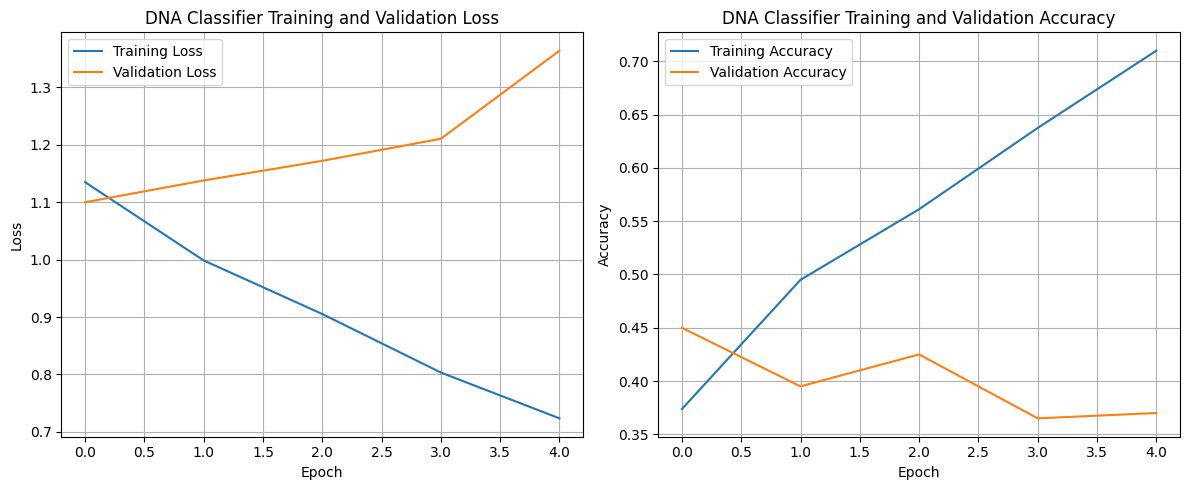

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies=None, val_accuracies=None, num_epochs=None, title=""):
    """
    Plots the training loss, training accuracy, validation loss, and validation accuracy.
    Args:
        train_losses: list of training losses
        val_losses: list of validation losses
        train_accuracies: list of training accuracies
        val_accuracies: list of validation accuracies
        num_epochs: number of epochs
        title: title of the plot
    """
    epochs_range = range(len(train_losses))

    plt.figure(figsize=(12, 5))

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1) # First plot in a 1x2 grid
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title(f'{title} Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Training and Validation Accuracy (if provided)
    if train_accuracies is not None and val_accuracies is not None:
        plt.subplot(1, 2, 2) # Second plot in a 1x2 grid
        plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
        plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
        plt.title(f'{title} Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_metrics(dna_train_losses, dna_val_losses, dna_train_accuracies, dna_val_accuracies, title="DNA Classifier")

Let's take the DNA classification model we just trained and apply it to our class Kaggle competition! Your homework folder should include a file called `dna_test.txt`, which contains 1377 DNA sequences. In the cell below, we've written a helper function for you that loads the `dna_test.txt` file, makes predictions for each DNA sequence, and saves the predictions to a csv file called `dna_test_predictions.csv`.

You should then submit your csv file to the Kaggle competition: [Fa25 CS189 HW4 - DNABERT](https://www.kaggle.com/competitions/fa-25-cs-189-hw-4-competition)

**Expected Output:**
* Your `dna_test_predictions.csv` file should have 2 columns:
    * `ID`: ID of the DNA sequence from the provided test set
    * `class`: the predicted species of the DNA sequence (0 for chimpanzee, 1 for dog, 2 for human).

**Task:**
* Train an instance of a DNA classifier. You have lots of freedom to try changing different parameters, such as how many epochs you train your model for, optimizer choice, learning rate, momentum values, etc.
    * You can also reuse your DNA classification model you trained in question 4g, but we encourage you to explore how you can improve your base model. The space of possibilities to try out is immense!
* Call `generate_dna_test_predictions` with your model to generate a `dna_test_predictions.csv` file.
* Submit your predictions to the DNA classification Kaggle competition.

In [17]:
def generate_dna_test_predictions(model) -> None:
    """
    Generates predictions for the DNA test set using the specified model.

    Loads the DNA test set from 'dna_test.txt', processes DNA sequences into k-mers,
    creates a DNADataset, and runs the model to obtain predictions for each sequence.
    Predictions are saved to 'dna_test_predictions.csv' with columns 'ID' and 'class'.

    Args:
        model (torch.nn.Module): Trained PyTorch model for DNA sequence classification.

    Outputs:
        dna_test_predictions.csv: CSV file with index column 'ID' and a 'class' column
        containing the predicted class for each dna sample in the test set.
    """
    # Load the DNA test set
    dna_test_df = pd.read_csv('dna_test.txt', sep='\t')
    dna_test_df.columns = ['ID', 'sequence']

    # Convert sequences to k-mers (space-separated strings for tokenizer)
    dna_kmers = dna_test_df['sequence'].apply(lambda seq: sequence_to_kmer(seq, k=6))

    # Create test dataset using DNADataset
    test_dataset = DNADataset(dna_kmers.tolist(), return_targets=False)

    # Create DataLoader
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Make predictions
    model.eval()
    predictions = []

    with torch.no_grad():
        for i in range(len(test_dataset)): # Iterate through all samples in our Dataset
            sample = test_dataset[i]
            input_ids = sample['input_ids'].unsqueeze(0).to(device)  # Add batch dimension: shape (1, seq_len of 512)
            attention_mask = sample['attention_mask'].unsqueeze(0).to(device)  # Add batch dimension: shape (1, seq_len of 512)

            outputs = model(input_ids, attention_mask)
            prediction = torch.argmax(outputs, dim=1).item()
            predictions.append(prediction)

    # Create predictions dataframe
    predictions_df = pd.DataFrame({
        'ID': dna_test_df['ID'],
        'class': predictions
    }).set_index('ID')

    predictions_df.to_csv('dna_test_predictions.csv', index=True) # Generates a csv with 2 columns: ID and class
    print("Submissions saved to dna_test_predictions.csv")

<!-- BEGIN QUESTION -->



In [ ]:
generate_dna_test_predictions(dna_classifier)

Submissions saved to dna_test_predictions.csv
